In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim
import torch
from tqdm import tqdm
import pickle
import time

In [2]:

pd.set_option('max_columns', 1000)

In [3]:
importlib.reload(utils)

<module 'data_formatters.utils' from '/Users/liuxufeng/github/tft/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [4]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('volatility', 'outputs_vol')

data_formatter = config.make_data_formatter()


print("*** Training from defined parameters for {} ***".format('m4'))
data_csv_path = "./volatility/formatted_omi_vol.csv"
#data_csv_path = '/Users/ardakeskiner/Desktop/TUM/Courses/ws19_20/tft/tft_outputs/data/electricity/hourly_electricity.csv'
print("Loading & splitting data...")
raw_data = pd.read_csv(data_csv_path, index_col=0)
print(raw_data.shape)
start = time.time()
train, valid, test = data_formatter.split_data(raw_data)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()
print(time.time()-start)



*** Training from defined parameters for m4 ***
Loading & splitting data...
(152280, 29)
Formatting train-valid-test splits.
Setting scalers with training data...
0.7153222560882568


In [5]:
raw_data

,Symbol,close_time,rk_th2,medrv,rv10,rv10_ss,rsv_ss,open_time,rv5,rv5_ss,open_to_close,bv,close_price,nobs,rsv,rk_parzen,rk_twoscale,bv_ss,open_price,date,days_from_start,day_of_week,day_of_month,week_of_year,month,year,categorical_id,log_vol,Region
2000-01-03 00:00:00+00:00,.AEX,163015.0,0.000102,0.000050,0.000178,0.000178,0.000046,90101.0,0.000130,0.000130,-0.000340,0.000100,675.44,1795.0,0.000046,0.000179,0.000103,0.000100,675.67,2000-01-03,0,0,3,1,1,2000,.AEX,-8.946668,EMEA
2000-01-04 00:00:00+00:00,.AEX,163016.0,0.000201,0.000075,0.000261,0.000261,0.000147,90416.0,0.000201,0.000201,-0.033606,0.000207,642.25,1785.0,0.000147,0.000423,0.000199,0.000207,664.20,2000-01-04,1,1,4,1,1,2000,.AEX,-8.510686,EMEA
2000-01-05 00:00:00+00:00,.AEX,163016.0,0.000345,0.000166,0.000714,0.000714,0.000328,90016.0,0.000491,0.000491,-0.001675,0.000361,632.31,1801.0,0.000328,0.000324,0.000325,0.000361,633.37,2000-01-05,2,2,5,1,1,2000,.AEX,-7.619135,EMEA
2000-01-06 00:00:00+00:00,.AEX,163002.0,0.000221,0.000152,0.000182,0.000182,0.000116,90016.0,0.000225,0.000225,-0.013130,0.000258,624.21,1799.0,0.000116,0.000219,0.000218,0.000258,632.46,2000-01-06,3,3,6,1,1,2000,.AEX,-8.398790,EMEA
2000-01-07 00:00:00+00:00,.AEX,163016.0,0.000123,0.000039,0.000157,0.000157,0.000048,90046.0,0.000138,0.000138,0.025013,0.000130,644.86,1798.0,0.000048,0.000155,0.000126,0.000130,628.93,2000-01-07,4,4,7,1,1,2000,.AEX,-8.885257,EMEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-17 00:00:00+01:00,.STOXX50E,183003.0,0.000027,0.000012,0.000025,0.000025,0.000011,100015.0,0.000022,0.000022,0.002966,0.000018,4157.22,4188.0,0.000011,0.000017,0.000026,0.000018,4144.91,2021-06-17,7836,3,17,24,6,2021,.STOXX50E,-10.721173,EMEA
2021-06-18 00:00:00+01:00,.STOXX50E,183003.0,0.000062,0.000022,0.000072,0.000072,0.000042,100015.0,0.000055,0.000055,-0.018567,0.000043,4079.33,4240.0,0.000042,0.000084,0.000061,0.000043,4155.78,2021-06-18,7837,4,18,24,6,2021,.STOXX50E,-9.816182,EMEA
2021-06-21 00:00:00+01:00,.STOXX50E,183006.0,0.000076,0.000024,0.000099,0.000099,0.000040,100015.0,0.000074,0.000074,0.007673,0.000071,4110.84,4124.0,0.000040,0.000096,0.000074,0.000071,4079.42,2021-06-21,7840,0,21,25,6,2021,.STOXX50E,-9.511787,EMEA
2021-06-22 00:00:00+01:00,.STOXX50E,183015.0,0.000034,0.000018,0.000036,0.000036,0.000014,100015.0,0.000031,0.000031,0.003665,0.000029,4127.44,4247.0,0.000014,0.000030,0.000034,0.000029,4112.34,2021-06-22,7841,1,22,25,6,2021,.STOXX50E,-10.384768,EMEA


In [6]:
# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

fixed_params.update(params)
fixed_params['batch_first'] = True
fixed_params['name'] = 'test'
fixed_params['device'] = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# fixed_params['minibatch_size'] = 64
# fixed_params['category_count'] = [6]
device = fixed_params['device']
fixed_params['quantiles'] = [0.5]

# with open('data_formatter_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(data_formatter, output, pickle.HIGHEST_PROTOCOL)



In [7]:
raw_data

,Symbol,close_time,rk_th2,medrv,rv10,rv10_ss,rsv_ss,open_time,rv5,rv5_ss,open_to_close,bv,close_price,nobs,rsv,rk_parzen,rk_twoscale,bv_ss,open_price,date,days_from_start,day_of_week,day_of_month,week_of_year,month,year,categorical_id,log_vol,Region
2000-01-03 00:00:00+00:00,.AEX,163015.0,0.000102,0.000050,0.000178,0.000178,0.000046,90101.0,0.000130,0.000130,-0.000340,0.000100,675.44,1795.0,0.000046,0.000179,0.000103,0.000100,675.67,2000-01-03,0,0,3,1,1,2000,.AEX,-8.946668,EMEA
2000-01-04 00:00:00+00:00,.AEX,163016.0,0.000201,0.000075,0.000261,0.000261,0.000147,90416.0,0.000201,0.000201,-0.033606,0.000207,642.25,1785.0,0.000147,0.000423,0.000199,0.000207,664.20,2000-01-04,1,1,4,1,1,2000,.AEX,-8.510686,EMEA
2000-01-05 00:00:00+00:00,.AEX,163016.0,0.000345,0.000166,0.000714,0.000714,0.000328,90016.0,0.000491,0.000491,-0.001675,0.000361,632.31,1801.0,0.000328,0.000324,0.000325,0.000361,633.37,2000-01-05,2,2,5,1,1,2000,.AEX,-7.619135,EMEA
2000-01-06 00:00:00+00:00,.AEX,163002.0,0.000221,0.000152,0.000182,0.000182,0.000116,90016.0,0.000225,0.000225,-0.013130,0.000258,624.21,1799.0,0.000116,0.000219,0.000218,0.000258,632.46,2000-01-06,3,3,6,1,1,2000,.AEX,-8.398790,EMEA
2000-01-07 00:00:00+00:00,.AEX,163016.0,0.000123,0.000039,0.000157,0.000157,0.000048,90046.0,0.000138,0.000138,0.025013,0.000130,644.86,1798.0,0.000048,0.000155,0.000126,0.000130,628.93,2000-01-07,4,4,7,1,1,2000,.AEX,-8.885257,EMEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-17 00:00:00+01:00,.STOXX50E,183003.0,0.000027,0.000012,0.000025,0.000025,0.000011,100015.0,0.000022,0.000022,0.002966,0.000018,4157.22,4188.0,0.000011,0.000017,0.000026,0.000018,4144.91,2021-06-17,7836,3,17,24,6,2021,.STOXX50E,-10.721173,EMEA
2021-06-18 00:00:00+01:00,.STOXX50E,183003.0,0.000062,0.000022,0.000072,0.000072,0.000042,100015.0,0.000055,0.000055,-0.018567,0.000043,4079.33,4240.0,0.000042,0.000084,0.000061,0.000043,4155.78,2021-06-18,7837,4,18,24,6,2021,.STOXX50E,-9.816182,EMEA
2021-06-21 00:00:00+01:00,.STOXX50E,183006.0,0.000076,0.000024,0.000099,0.000099,0.000040,100015.0,0.000074,0.000074,0.007673,0.000071,4110.84,4124.0,0.000040,0.000096,0.000074,0.000071,4079.42,2021-06-21,7840,0,21,25,6,2021,.STOXX50E,-9.511787,EMEA
2021-06-22 00:00:00+01:00,.STOXX50E,183015.0,0.000034,0.000018,0.000036,0.000036,0.000014,100015.0,0.000031,0.000031,0.003665,0.000029,4127.44,4247.0,0.000014,0.000030,0.000034,0.000029,4112.34,2021-06-22,7841,1,22,25,6,2021,.STOXX50E,-10.384768,EMEA


In [8]:
fixed_params

{'total_time_steps': 257,
 'num_encoder_steps': 252,
 'num_epochs': 100,
 'early_stopping_patience': 5,
 'multiprocessing_workers': 5,
 'column_definition': [('Symbol',
   <DataTypes.CATEGORICAL: 1>,
   <InputTypes.ID: 4>),
  ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>),
  ('log_vol', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>),
  ('open_to_close',
   <DataTypes.REAL_VALUED: 0>,
   <InputTypes.OBSERVED_INPUT: 1>),
  ('days_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('day_of_week', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('day_of_month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('week_of_year', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('Region', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)],
 'input_size': 8,
 'output_size': 1,
 'category_counts': [7, 31, 53, 12, 4],
 'input_obs_loc': [0],
 'static_input

In [9]:
max_samples = 256  #* 200 * 2
elect = ts_dataset.TSDataset(fixed_params, max_samples, train)

# with open('ts_dataset_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(elect, output, pickle.HIGHEST_PROTOCOL)

# with open('ts_dataset_m4.pkl', 'rb') as input:
#     elect = pickle.load(input)

Getting valid sampling locations.
# available segments=101946
Extracting 256 samples...


In [10]:
loader = DataLoader(
            elect,
            batch_size=fixed_params['minibatch_size'],
            num_workers=2,
            shuffle=False
        )

In [11]:
importlib.reload(tft_model)
model = tft_model.TFT(fixed_params).to(device)

{'total_time_steps': 257, 'num_encoder_steps': 252, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('Symbol', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('log_vol', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('open_to_close', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('days_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('day_of_week', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('day_of_month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('week_of_year', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('Region', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 8, 'output_size': 1, 'category_counts': [7, 31, 53, 12, 4], 'input_obs_loc': [0], 'static_input_loc': [7], 'known_regular_inputs': [2],

In [12]:
from losses.quantile_loss import QuantileLoss
from losses.smape_loss import SMAPELoss
from losses.rmsse_loss import RMSSELoss
from losses.pinball_loss import PinballLoss


q_loss_func = RMSSELoss(fixed_params['device'])
# q_loss_func = SMAPELoss(fixed_params['device'])
# q_loss_func = QuantileLoss(fixed_params['quantiles'])
# import sys
# sys.path.append('/home/arda/Desktop/thesis/')
# from loss_modules import PinballLoss
q_loss_func = PinballLoss(0.45, device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
model.train()
epochs=100
losses = []
for i in range(epochs):
    epoch_loss = []
    progress_bar = tqdm(enumerate(loader), total=len(loader))
    for batch_num, batch in progress_bar:
        optimizer.zero_grad()
        output, all_inputs, attention_components = model(batch['inputs'])
#         loss= q_loss_func(output[:,:,:].view(-1,1), batch['outputs'][:,:,0].flatten().float().to(device))
        loss = q_loss_func(output.squeeze(2), batch['outputs'][:,:,0].float().to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), fixed_params['max_gradient_norm'])
        optimizer.step()
        epoch_loss.append(loss.item())
    
    losses.append(np.mean(epoch_loss))
    if loss.item() <= min(losses):
        torch.save(model.state_dict(), 'electricity_best_model_smape_loss.pth')
        
    print(np.mean(epoch_loss))
    

  0%|          | 0/4 [00:00<?, ?it/s]/Users/liuxufeng/github/tft/Temporal_Fusion_Transform/layers/scaled_dot_product_attention.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mmask = (-1e+9) * (1. - torch.tensor(mask, dtype=torch.float).to(self.device)) # setting to infinity
100%|██████████| 4/4 [00:23<00:00,  5.89s/it]

0.20105988904833794



100%|██████████| 4/4 [00:20<00:00,  5.24s/it]

0.2139316089451313



100%|██████████| 4/4 [00:22<00:00,  5.51s/it]

0.208828654140234



100%|██████████| 4/4 [00:20<00:00,  5.22s/it]

0.18824032694101334



100%|██████████| 4/4 [00:20<00:00,  5.03s/it]

0.19696342572569847



100%|██████████| 4/4 [00:20<00:00,  5.20s/it]

0.19871504232287407



100%|██████████| 4/4 [00:20<00:00,  5.11s/it]

0.19453173503279686



100%|██████████| 4/4 [00:20<00:00,  5.17s/it]

0.19206399098038673



100%|██████████| 4/4 [00:20<00:00,  5.08s/it]

0.18037383258342743



100%|██████████| 4/4 [00:20<00:00,  5.20s/it]

0.18575768545269966



100%|██████████| 4/4 [00:21<00:00,  5.35s/it]

0.17962690815329552



100%|██████████| 4/4 [00:21<00:00,  5.44s/it]

0.17655588686466217



100%|██████████| 4/4 [00:21<00:00,  5.45s/it]

0.17722589895129204



100%|██████████| 4/4 [00:22<00:00,  5.57s/it]

0.17489897087216377



100%|██████████| 4/4 [00:21<00:00,  5.32s/it]

0.16845453903079033



100%|██████████| 4/4 [00:23<00:00,  5.83s/it]

0.1691385805606842



100%|██████████| 4/4 [00:27<00:00,  6.83s/it]

0.17388681322336197



100%|██████████| 4/4 [00:23<00:00,  5.76s/it]

0.17200103774666786



100%|██████████| 4/4 [00:21<00:00,  5.48s/it]

0.1659979522228241



100%|██████████| 4/4 [00:21<00:00,  5.26s/it]

0.17850008606910706



100%|██████████| 4/4 [00:20<00:00,  5.19s/it]

0.16889535263180733



100%|██████████| 4/4 [00:20<00:00,  5.17s/it]

0.16061701253056526



100%|██████████| 4/4 [00:20<00:00,  5.21s/it]

0.1635524109005928



100%|██████████| 4/4 [00:20<00:00,  5.23s/it]

0.15828213468194008



100%|██████████| 4/4 [00:21<00:00,  5.36s/it]

0.16280804574489594



100%|██████████| 4/4 [00:20<00:00,  5.24s/it]

0.1559782437980175



100%|██████████| 4/4 [00:20<00:00,  5.17s/it]

0.16271112859249115



100%|██████████| 4/4 [00:20<00:00,  5.00s/it]

0.1568349003791809



100%|██████████| 4/4 [00:19<00:00,  4.83s/it]

0.15956350415945053



100%|██████████| 4/4 [00:19<00:00,  4.76s/it]

0.15229786187410355



100%|██████████| 4/4 [00:19<00:00,  4.81s/it]

0.15191073343157768



100%|██████████| 4/4 [00:19<00:00,  4.90s/it]

0.15397119894623756



100%|██████████| 4/4 [00:20<00:00,  5.06s/it]

0.146436408162117



100%|██████████| 4/4 [00:21<00:00,  5.31s/it]

0.1493171490728855



100%|██████████| 4/4 [00:21<00:00,  5.41s/it]

0.14324379712343216



100%|██████████| 4/4 [00:21<00:00,  5.45s/it]

0.1454581655561924



100%|██████████| 4/4 [00:21<00:00,  5.41s/it]

0.1522667296230793



100%|██████████| 4/4 [00:22<00:00,  5.51s/it]

0.14166563004255295



100%|██████████| 4/4 [00:22<00:00,  5.60s/it]

0.14406223595142365



100%|██████████| 4/4 [00:23<00:00,  5.86s/it]

0.15119578689336777



100%|██████████| 4/4 [00:22<00:00,  5.62s/it]

0.1370375044643879



100%|██████████| 4/4 [00:23<00:00,  5.77s/it]

0.13734178617596626



100%|██████████| 4/4 [00:23<00:00,  5.79s/it]

0.13573790341615677



100%|██████████| 4/4 [00:23<00:00,  5.79s/it]

0.13303061202168465



100%|██████████| 4/4 [00:23<00:00,  5.93s/it]

0.13029734045267105



100%|██████████| 4/4 [00:23<00:00,  5.86s/it]

0.1359279304742813



100%|██████████| 4/4 [00:23<00:00,  5.97s/it]

0.13125287555158138



100%|██████████| 4/4 [00:23<00:00,  5.88s/it]

0.13575487583875656



100%|██████████| 4/4 [00:23<00:00,  5.93s/it]

0.13759123161435127



100%|██████████| 4/4 [00:23<00:00,  5.89s/it]

0.13727178797125816



100%|██████████| 4/4 [00:23<00:00,  5.80s/it]

0.13630709052085876



100%|██████████| 4/4 [00:23<00:00,  5.84s/it]

0.13651347905397415



100%|██████████| 4/4 [00:24<00:00,  6.16s/it]

0.1275041587650776



100%|██████████| 4/4 [00:24<00:00,  6.21s/it]

0.12210654281079769



100%|██████████| 4/4 [00:25<00:00,  6.29s/it]

0.12172857858240604



100%|██████████| 4/4 [00:23<00:00,  5.99s/it]

0.1264957506209612



100%|██████████| 4/4 [00:24<00:00,  6.18s/it]

0.11876292154192924



100%|██████████| 4/4 [00:24<00:00,  6.06s/it]

0.12079351022839546



100%|██████████| 4/4 [00:24<00:00,  6.03s/it]

0.12639504298567772



100%|██████████| 4/4 [00:23<00:00,  5.83s/it]

0.1260269656777382



100%|██████████| 4/4 [00:23<00:00,  5.92s/it]

0.12465784139931202



100%|██████████| 4/4 [00:23<00:00,  5.85s/it]

0.11948569305241108



100%|██████████| 4/4 [00:24<00:00,  6.18s/it]

0.11620031297206879



100%|██████████| 4/4 [00:24<00:00,  6.07s/it]

0.1180279441177845



100%|██████████| 4/4 [00:24<00:00,  6.15s/it]

0.11100633814930916



100%|██████████| 4/4 [00:24<00:00,  6.13s/it]

0.11333122290670872



100%|██████████| 4/4 [00:23<00:00,  5.94s/it]

0.11685311421751976



100%|██████████| 4/4 [00:23<00:00,  5.98s/it]

0.12063125148415565



100%|██████████| 4/4 [00:25<00:00,  6.30s/it]

0.12267944775521755



100%|██████████| 4/4 [00:24<00:00,  6.21s/it]

0.11258602514863014



100%|██████████| 4/4 [00:23<00:00,  5.98s/it]

0.12116366252303123



100%|██████████| 4/4 [00:25<00:00,  6.35s/it]

0.11824658326804638



100%|██████████| 4/4 [00:24<00:00,  6.20s/it]

0.10972729697823524



100%|██████████| 4/4 [00:25<00:00,  6.28s/it]

0.11047529801726341



100%|██████████| 4/4 [00:25<00:00,  6.26s/it]

0.11522977985441685



100%|██████████| 4/4 [00:24<00:00,  6.01s/it]

0.11098717711865902



100%|██████████| 4/4 [00:24<00:00,  6.12s/it]

0.10229074023663998



100%|██████████| 4/4 [00:24<00:00,  6.17s/it]

0.11383495852351189



100%|██████████| 4/4 [00:25<00:00,  6.42s/it]

0.10782472603023052



100%|██████████| 4/4 [00:24<00:00,  6.06s/it]

0.10772048868238926



100%|██████████| 4/4 [00:24<00:00,  6.12s/it]

0.11813926510512829



100%|██████████| 4/4 [00:25<00:00,  6.27s/it]

0.10966410674154758



100%|██████████| 4/4 [00:26<00:00,  6.74s/it]

0.10950251668691635



100%|██████████| 4/4 [00:26<00:00,  6.71s/it]

0.11362646892666817



100%|██████████| 4/4 [00:27<00:00,  6.86s/it]

0.10860522277653217



100%|██████████| 4/4 [00:25<00:00,  6.45s/it]

0.10777377709746361



100%|██████████| 4/4 [00:26<00:00,  6.53s/it]

0.09462765045464039



100%|██████████| 4/4 [00:24<00:00,  6.02s/it]

0.09930544160306454



100%|██████████| 4/4 [00:24<00:00,  6.23s/it]

0.09691095165908337



100%|██████████| 4/4 [00:24<00:00,  6.13s/it]

0.10110968723893166



100%|██████████| 4/4 [00:24<00:00,  6.00s/it]

0.10571355931460857



100%|██████████| 4/4 [00:23<00:00,  5.97s/it]

0.10702589340507984



100%|██████████| 4/4 [00:24<00:00,  6.00s/it]

0.10417257621884346



100%|██████████| 4/4 [00:25<00:00,  6.40s/it]

0.0976682286709547



100%|██████████| 4/4 [00:25<00:00,  6.35s/it]

0.09859144873917103



100%|██████████| 4/4 [00:25<00:00,  6.37s/it]

0.09683774225413799



100%|██████████| 4/4 [00:24<00:00,  6.23s/it]

0.09475506655871868



100%|██████████| 4/4 [00:25<00:00,  6.30s/it]

0.0955550279468298



100%|██████████| 4/4 [00:25<00:00,  6.40s/it]

0.09043684601783752



100%|██████████| 4/4 [00:25<00:00,  6.36s/it]

0.093032943084836


19


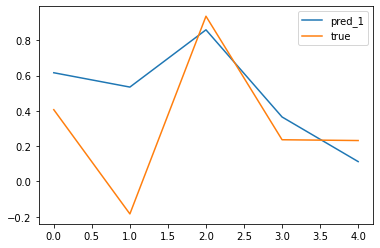

In [28]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
# plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
# plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()

In [20]:
def symmetric_mean_absolute_percentage_error(forecast, actual):
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    sequence_length = forecast.shape[1]
    sumf = np.sum(np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)), axis=1)
    return np.mean((2 * sumf) / sequence_length)

In [21]:
symmetric_mean_absolute_percentage_error(output[:,:,0].detach().cpu().numpy(),
                                        batch['outputs'][:,:,0].detach().cpu().numpy())



0.60055388659385